In [1]:
import sys
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
from scipy.stats import ttest_1samp
%matplotlib inline

if '..' not in sys.path:
    sys.path.append('..')
import make_bayes_submission
from make_submission import sigmoid, logit

In [2]:
train_flat = pd.read_csv('../../_data/train_flat.csv', index_col=0)
train_flat[:3]

,agriculture,artisinal_mine,bare_ground,blooming,blow_down,clear,cloudy,conventional_mine,cultivation,habitation,haze,partly_cloudy,primary,road,selective_logging,slash_burn,water
image_name,,,,,,,,,,,,,,,,,
train_0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
train_1,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1
train_2,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0


In [156]:
sample_submission = pd.read_csv('../../_data/sample_submission_v2.csv', index_col=0)
sample_submission[:3]

,tags
image_name,
test_0,primary clear agriculture road water
test_1,primary clear agriculture road water
test_2,primary clear agriculture road water


In [3]:
valid_pred = pd.read_hdf('../../_data/20170720-005737-b6-albu-0.93359-eval.h5').loc[train_flat.index]
valid_pred = valid_pred.loc[train_flat.index]
valid_pred[:3]

,agriculture,artisinal_mine,bare_ground,blooming,blow_down,clear,cloudy,conventional_mine,cultivation,habitation,haze,partly_cloudy,primary,road,selective_logging,slash_burn,water
image_name,,,,,,,,,,,,,,,,,
train_0,0.003930,0.004211,0.002263,0.001794,0.002070,0.591027,0.006670,0.001795,0.002431,0.002176,0.683836,0.002359,0.997151,0.002328,0.002150,0.001753,0.003885
train_1,0.818843,0.005387,0.014422,0.001886,0.001836,0.997251,0.003316,0.002329,0.455737,0.028945,0.002248,0.002191,0.997231,0.500173,0.004191,0.016922,0.818798
train_2,0.003150,0.003586,0.002302,0.001734,0.001651,0.997664,0.004536,0.001653,0.001856,0.002268,0.001843,0.002075,0.997267,0.002243,0.002193,0.002039,0.002790


In [55]:
valid_pred_2 = pd.read_hdf('../../_data/20170718-234554-b5-albu-eval.h5').loc[train_flat.index]
valid_pred_2 = valid_pred_2.loc[train_flat.index]
valid_pred_2[:3]

,agriculture,artisinal_mine,bare_ground,blooming,blow_down,clear,cloudy,conventional_mine,cultivation,habitation,haze,partly_cloudy,primary,road,selective_logging,slash_burn,water
image_name,,,,,,,,,,,,,,,,,
train_0,0.004018,0.002505,0.002335,0.002023,0.001570,0.564935,0.004454,0.001158,0.002751,0.002372,0.683979,0.002067,0.997527,0.002525,0.001848,0.001840,0.003917
train_1,0.817122,0.003267,0.016906,0.001994,0.001630,0.997239,0.003767,0.001254,0.460328,0.032931,0.002022,0.002043,0.997559,0.525844,0.003418,0.016891,0.826382
train_2,0.003122,0.002086,0.002283,0.001856,0.001547,0.997508,0.004618,0.001149,0.002176,0.002374,0.001877,0.001882,0.997805,0.002592,0.001828,0.001718,0.003053


In [54]:
valid_pred_3 = pd.read_hdf('../../_data/train_mean2_01_09_0.933540_uncalibrated.h5').loc[train_flat.index]
valid_pred_3 = valid_pred_3.loc[train_flat.index]
valid_pred_3[:3]

,agriculture,artisinal_mine,bare_ground,blooming,blow_down,clear,cloudy,conventional_mine,cultivation,habitation,haze,partly_cloudy,primary,road,selective_logging,slash_burn,water
image_name,,,,,,,,,,,,,,,,,
train_0,0.003113,0.000162,0.000521,0.000485,0.000340,0.420503,0.000231,0.000091,0.001288,0.001112,0.579858,0.000343,0.999621,0.001048,0.000420,0.000146,0.002709
train_1,0.789577,0.000953,0.019854,0.000415,0.000505,0.998904,0.000171,0.000254,0.298429,0.033271,0.000574,0.000375,0.999673,0.354220,0.002517,0.028999,0.770127
train_2,0.002829,0.000195,0.000495,0.000262,0.000376,0.999148,0.000208,0.000224,0.000850,0.001200,0.000485,0.000307,0.999714,0.000747,0.000391,0.000179,0.001632


In [65]:
valid_pred_4 = pd.read_hdf('../../_data/20170720-230454-b6-0.93359-eval.h5').loc[train_flat.index]
valid_pred_4 = valid_pred_4.loc[train_flat.index]
valid_pred_4[:3]

,agriculture,artisinal_mine,bare_ground,blooming,blow_down,clear,cloudy,conventional_mine,cultivation,habitation,haze,partly_cloudy,primary,road,selective_logging,slash_burn,water
image_name,,,,,,,,,,,,,,,,,
train_0,0.001607,0.000020,0.000129,0.000260,0.000047,0.783056,0.000066,0.000019,0.001060,0.000264,0.845964,0.000842,0.999914,0.000517,0.000069,0.000055,0.002081
train_1,0.906032,0.001333,0.006105,0.000215,0.000233,0.999280,0.000011,0.000175,0.736821,0.021277,0.000135,0.000616,0.999910,0.762156,0.001573,0.006703,0.904305
train_2,0.000343,0.000002,0.000013,0.000081,0.000016,0.999854,0.000006,0.000002,0.000162,0.000038,0.000035,0.000094,0.999987,0.000087,0.000012,0.000004,0.000215


In [83]:
valid_pred_5 = pd.read_hdf('../../_data/train_mean3_0.933338_uncalibrated.h5').loc[train_flat.index]
valid_pred_5 = valid_pred_5.loc[train_flat.index]
valid_pred_5[:3]

,agriculture,artisinal_mine,bare_ground,blooming,blow_down,clear,cloudy,conventional_mine,cultivation,habitation,haze,partly_cloudy,primary,road,selective_logging,slash_burn,water
image_name,,,,,,,,,,,,,,,,,
train_0,0.005478,0.007004,0.003685,0.002817,0.003418,0.463008,0.011074,0.002979,0.003345,0.003450,0.575751,0.003370,0.995309,0.003536,0.003538,0.002884,0.005087
train_1,0.760717,0.008090,0.019966,0.003001,0.002905,0.995899,0.005518,0.003765,0.268348,0.034056,0.003656,0.003242,0.995445,0.325517,0.005937,0.023736,0.761794
train_2,0.005020,0.005975,0.003828,0.002836,0.002740,0.996203,0.007556,0.002753,0.002985,0.003755,0.003048,0.003396,0.995453,0.003681,0.003647,0.003395,0.004506


In [158]:
valid_pred_6 = pd.read_hdf('../../_data/20170720-232049-b7-albu-0.93374-eval.h5').loc[train_flat.index]
valid_pred_6 = valid_pred_6.loc[train_flat.index]
test_pred_6 = pd.read_hdf('../../_data/20170720-232049-b7-albu-0.93374-test.h5').loc[sample_submission.index]
valid_pred_6[:3]

,agriculture,artisinal_mine,bare_ground,blooming,blow_down,clear,cloudy,conventional_mine,cultivation,habitation,haze,partly_cloudy,primary,road,selective_logging,slash_burn,water
image_name,,,,,,,,,,,,,,,,,
train_0,0.002963,0.001474,0.000997,0.000863,0.000838,0.572981,0.002333,0.000639,0.001613,0.001248,0.687477,0.001129,0.998874,0.001342,0.000903,0.000655,0.002938
train_1,0.832720,0.002540,0.014506,0.000850,0.000874,0.998447,0.001177,0.000931,0.468102,0.028495,0.001016,0.001049,0.998922,0.512371,0.002825,0.019032,0.823038
train_2,0.002260,0.001274,0.000968,0.000703,0.000705,0.998847,0.001597,0.000641,0.000994,0.001245,0.000816,0.000836,0.998971,0.001067,0.000890,0.000752,0.001634


In [160]:
valid_pred_7 = pd.read_hdf('../../_data/train_mean3_0.933493_uncalibrated.h5').loc[train_flat.index]
valid_pred_7 = valid_pred_7.loc[train_flat.index]
test_pred_7 = pd.read_hdf('../../_data/test_mean3_0.933493_uncalibrated.h5').loc[sample_submission.index]
valid_pred_7[:3]

,agriculture,artisinal_mine,bare_ground,blooming,blow_down,clear,cloudy,conventional_mine,cultivation,habitation,haze,partly_cloudy,primary,road,selective_logging,slash_burn,water
image_name,,,,,,,,,,,,,,,,,
train_0,0.004879,0.003779,0.002665,0.002121,0.002582,0.451819,0.006361,0.002168,0.002718,0.002693,0.575163,0.002152,0.996973,0.002847,0.002302,0.002034,0.004316
train_1,0.784487,0.004635,0.019762,0.002113,0.002110,0.997018,0.003775,0.002555,0.277725,0.035275,0.002609,0.002202,0.997030,0.355802,0.004173,0.027381,0.770486
train_2,0.004401,0.003441,0.002696,0.002003,0.002313,0.997293,0.005412,0.002142,0.002374,0.002891,0.002398,0.002150,0.997139,0.002629,0.002225,0.002380,0.003495


In [4]:
def f2_score(y_true, y_pred, eps=1e-7) -> float:
    # same as fbeta_score(y_true, y_pred, beta=2, average='samples')
    # but faster
    if isinstance(y_true, pd.DataFrame):
        y_true = y_true.as_matrix()
    if isinstance(y_pred, pd.DataFrame):
        y_pred = y_pred.as_matrix()
    tp = (y_true * y_pred).sum(axis=1)
    r = tp / y_true.sum(axis=1)
    p = tp / (y_pred.sum(axis=1) + eps)
    beta2 = 4
    f2 = (1 + beta2) * p * r / (beta2 * p + r + eps)
    return f2.mean()

In [5]:
threshold = 0.2
original_score = f2_score(train_flat, valid_pred > threshold)
original_score

0.93359010922228391

In [60]:
f2_score(train_flat, valid_pred_3 > 0.2)

0.93354022237067436

In [66]:
f2_score(train_flat, valid_pred_4 > 0.2)

0.93359446493753029

In [140]:
f2_score(train_flat, (0.5 * valid_pred_4 + 0.5 * valid_pred_3) > 0.2)

0.93360830126324112

In [85]:
f2_score(train_flat, valid_pred_5 > 0.2)

0.93333823002426741

In [139]:
f2_score(train_flat, (0.5 * valid_pred_4 + 0.5 * valid_pred_5) > 0.2)

0.93360806943640218

In [93]:
f2_score(train_flat, valid_pred_6 > 0.2)

0.93373588709201194

In [134]:
f2_score(train_flat, sigmoid(logit(valid_pred_6) - 0.2) > 0.2)

0.93379706280631225

In [138]:
f2_score(train_flat, valid_pred_7 > 0.2)

0.9334928304822665

In [142]:
f2_score(train_flat, 0.5 * (valid_pred_6 + valid_pred_7) > 0.2)

0.93360818030809334

In [100]:
for th in np.linspace(0.15, 0.35, 20):
    score = f2_score(train_flat, valid_pred_6 > th)
    if score > original_score:
        print('{:.4f} {:.7f}'.format(th, score - original_score))

0.1921 0.0001493
0.2026 0.0001419
0.2132 0.0001353
0.2237 0.0001653
0.2342 0.0002110
0.2447 0.0001804
0.2553 0.0002543
0.2658 0.0002270
0.2763 0.0001657
0.2868 0.0000794
0.3079 0.0000220
0.3184 0.0000141


In [95]:
for th in np.linspace(0.15, 0.35, 20):
    score = f2_score(train_flat, valid_pred > th)
    if score > original_score:
        print('{:.4f} {:.7f}'.format(th, score - original_score))

0.1921 0.0000093
0.2132 0.0000581
0.2342 0.0000146
0.2447 0.0000436
0.2553 0.0000147
0.2658 0.0000716
0.2763 0.0000965
0.2868 0.0001058
0.2974 0.0000973
0.3079 0.0000670
0.3184 0.0001016
0.3289 0.0000919
0.3395 0.0000696


best th 0.261, valid delta +0.000058
best th 0.261, valid delta -0.000480
best th 0.261, valid delta -0.000577
best th 0.261, valid delta +0.000488
best th 0.261, valid delta +0.000194
best th 0.257, valid delta +0.000053
best th 0.261, valid delta +0.000098
best th 0.261, valid delta +0.000329
best th 0.237, valid delta +0.000097
best th 0.257, valid delta +0.000360
Mean delta +0.00006, mean threshold 0.258
T-test: Ttest_1sampResult(statistic=0.56927505634513376, pvalue=0.58309585849237022)


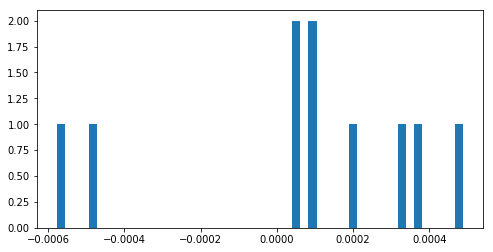

In [96]:
deltas = []
thresholds = []
for train_ids, valid_ids in KFold(n_splits=10, shuffle=True).split(valid_pred_6.index):
    best_score = 0
    best_th = 0.2
    for th in np.linspace(0.15, 0.35, 100):
        score = f2_score(train_flat.iloc[train_ids], valid_pred_6.iloc[train_ids] > th)
        if score > best_score:
            best_score = score
            best_th = th
    delta = (f2_score(train_flat.iloc[valid_ids], valid_pred_6.iloc[valid_ids] > best_th) -
             f2_score(train_flat.iloc[valid_ids], valid_pred_6.iloc[valid_ids] > 0.2))
    deltas.append(delta)
    thresholds.append(best_th)
    print('best th {:.3f}, valid delta {:+.6f}'.format(best_th, delta))
    # print('{:+.5f}'.format(delta))
plt.figure(figsize=(8, 4))
plt.hist(deltas, bins=50);
print('Mean delta {:+.5f}, mean threshold {:.3f}'.format(np.mean(deltas), np.mean(thresholds)))
print('T-test: {}'.format(ttest_1samp(deltas, 0)))

In [171]:
def check_weather(valid, a, b, threshold=0.2):
    deltas = []
    scores = []
    for _ in range(100):
        for train_ids, valid_ids in KFold(n_splits=10, shuffle=True).split(valid.index):
            hack = valid.iloc[valid_ids].copy()
            hack[hack['cloudy'] > a] *= b
            f2_score(train_flat.iloc[valid_ids], hack > threshold)
            delta = (score - f2_score(train_flat.iloc[valid_ids], valid.iloc[valid_ids] > threshold))
            deltas.append(delta)
            scores.append(score)
            # print('{:+.5f}'.format(delta))
    plt.figure(figsize=(8, 4))
    plt.hist(deltas, bins=50);
    print('Mean delta {:+.6f}, mean score {:.6f}'.format(np.mean(deltas), np.mean(scores)))
    print('T-test: {}'.format(ttest_1samp(deltas, 0)))

Mean delta -0.000284, mean score 0.933364
T-test: Ttest_1sampResult(statistic=-5.2084247499210914, pvalue=2.3124802512023378e-07)


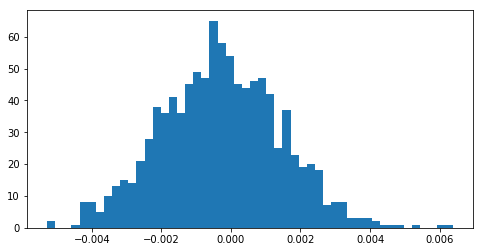

In [172]:
check_weather(0.7 * valid_pred_6 + 0.3 * valid_pred_7, 0.8, 0.8)

In [46]:
base_score = f2_score(train_flat, valid_pred > threshold)
bayes_valid = make_bayes_submission.get_df_prediction(valid_pred, add_hacks=False)
new_score = f2_score(train_flat, bayes_valid)
print('{:.6f}, {:.6f}'.format(new_score, new_score - base_score))
# 0.933706, 0.000116 hacks
# 0.933658, 0.000068 no hacks

0.933658, 0.000068


In [40]:
(train_ids, valid_ids), _ = KFold(n_splits=2, shuffle=True, random_state=42).split(train_flat.index)
base_score = f2_score(train_flat.iloc[train_ids], valid_pred.iloc[train_ids] > threshold)
bayes_valid = make_bayes_submission.get_df_prediction(
    valid_pred.iloc[train_ids], add_hacks=True)
new_score = f2_score(train_flat.iloc[train_ids], bayes_valid)
print('{:.6f}, {:.6f}'.format(new_score, new_score - base_score))
# train
# 0.933590, 0.000054 base
# 0.933624, 0.000087 cloudy + x *= 0.9
# 0.933666, 0.000130 cloudy + x *= 0.9 | multiweather *= 0.9
# 0.933666, 0.000140 cloudy + x *= 0.9 | multiweather *= 0.9 | cloudy + primary *= 0.87
# valid
# 0.933725, 0.000081 base
# 0.933735, 0.000091 cloudy + x *= 0.9 | multiweather *= 0.9 | cloudy + primary *= 0.87

0.933677, 0.000140


In [43]:
base_score = f2_score(train_flat.iloc[valid_ids], valid_pred.iloc[valid_ids] > threshold)
bayes_valid = make_bayes_submission.get_df_prediction(
    valid_pred.iloc[valid_ids], add_hacks=True)
new_score = f2_score(train_flat.iloc[valid_ids], bayes_valid)
print('{:.6f}, {:.6f}'.format(new_score, new_score - base_score))

0.933735, 0.000091


In [55]:
for alpha in [0.05, 0.1, 0.15]:
    new_score = f2_score(
        train_flat,
        make_bayes_submission.get_df_prediction(valid_pred * (1 + alpha)))
    print('alpha={:.2f}, score={:.6f}, delta={:.6f}'.format(alpha, new_score, new_score - original_score))

alpha=0.05, score=0.933632, delta=0.000042
alpha=0.10, score=0.933638, delta=0.000048
alpha=0.15, score=0.933538, delta=-0.000052


In [35]:
for delta in [-0.03, -0.01, 0.01, 0.03]:
    new_score = f2_score(
        train_flat,
        make_bayes_submission.get_df_prediction(sigmoid(logit(valid_pred) + delta)))
    print('delta={:.2f}, score={:.6f}, delta={:.6f}'.format(delta, new_score, new_score - original_score))

delta=-0.05, score=0.933657, delta=0.000066
delta=-0.10, score=0.933619, delta=0.000027
delta=0.05, score=0.933533, delta=-0.000058


In [45]:
new_score = f2_score(train_flat, make_bayes_submission.get_df_prediction(valid_pred, min_p=0.03, max_p=0.5))
print('{:.6f}, {:.6f}'.format(new_score, new_score - original_score))

0.933270, 0.000061


In [122]:
def check_bayes(valid, add_hacks):
    bayes = make_bayes_submission.get_df_prediction(valid, add_hacks=add_hacks)
    deltas = []
    scores = []
    for _ in range(100):
        for train_ids, valid_ids in KFold(n_splits=10, shuffle=True).split(valid.index):
            score = f2_score(train_flat.iloc[valid_ids], bayes.iloc[valid_ids])
            scores.append(score)
            delta = (score - f2_score(train_flat.iloc[valid_ids], valid.iloc[valid_ids] > 0.2))
            deltas.append(delta)
    plt.figure(figsize=(8, 4))
    plt.hist(deltas, bins=50);
    print('Mean delta {:+.6f}, mean score {:.6f}'.format(np.mean(deltas), np.mean(scores)))
    print('T-test: {}'.format(ttest_1samp(deltas, 0)))

Mean delta +0.000068, mean score +0.933658
T-test: Ttest_1sampResult(statistic=8.7292295446403365, pvalue=1.0604579365516302e-17)


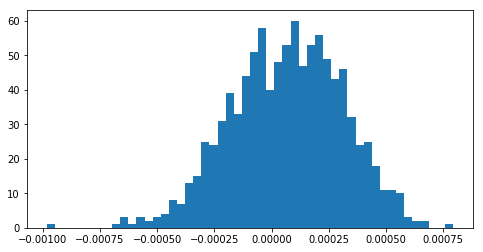

In [120]:
check_bayes(valid_pred, add_hacks=False)

Mean delta +0.000116, mean score +0.933706
T-test: Ttest_1sampResult(statistic=13.677891452416464, pvalue=3.6556560861735683e-39)


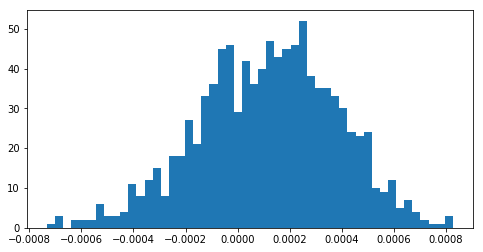

In [121]:
check_bayes(valid_pred, add_hacks=True)

Mean delta +0.000142
T-test: Ttest_1sampResult(statistic=13.281556082660087, pvalue=3.4413562151125698e-37)


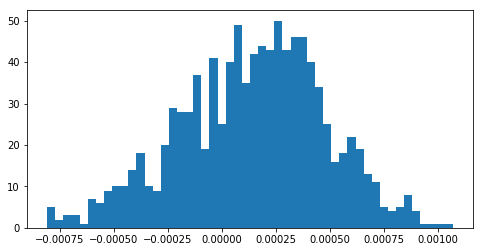

In [76]:
check_bayes(valid_pred_2, add_hacks=False)

Mean delta +0.000147
T-test: Ttest_1sampResult(statistic=12.342327469420757, pvalue=1.1259740752972426e-32)


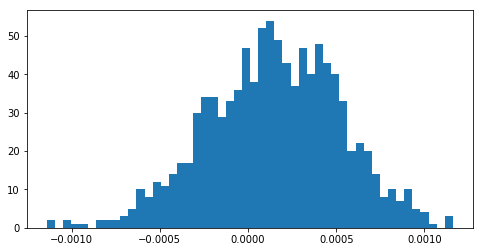

In [77]:
check_bayes(valid_pred_2, add_hacks=True)

Mean delta -0.000244
T-test: Ttest_1sampResult(statistic=-16.28179586542425, pvalue=4.822686489150312e-53)


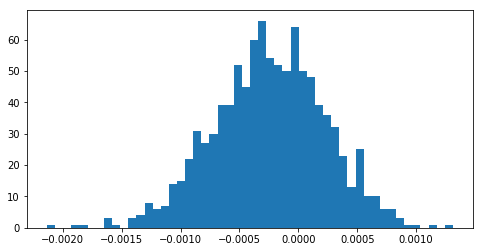

In [78]:
check_bayes(valid_pred_3, add_hacks=False)

Mean delta -0.000374
T-test: Ttest_1sampResult(statistic=-20.243030252549111, pvalue=1.2731965408793187e-76)


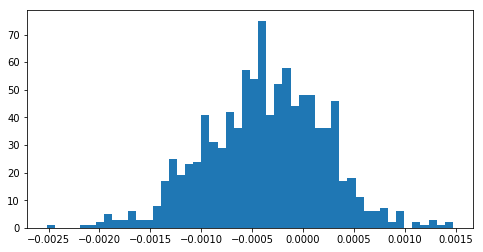

In [79]:
check_bayes(valid_pred_3, add_hacks=True)

Mean delta +0.000086
T-test: Ttest_1sampResult(statistic=18.103065197617955, pvalue=1.4418766348971896e-63)


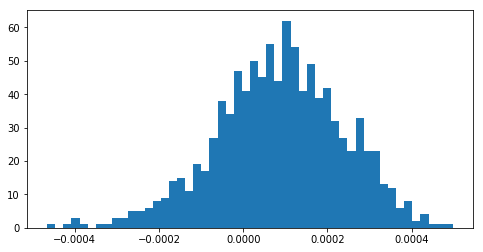

In [80]:
check_bayes(valid_pred_4, add_hacks=False)

Mean delta +0.000086
T-test: Ttest_1sampResult(statistic=15.995696171463731, pvalue=1.9049774633665546e-51)


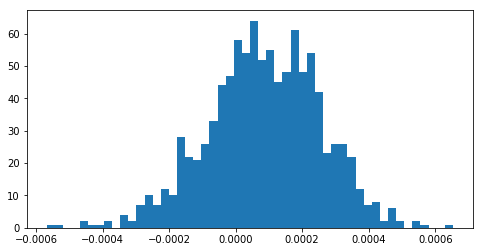

In [81]:
check_bayes(valid_pred_4, add_hacks=True)

Mean delta -0.000169
T-test: Ttest_1sampResult(statistic=-11.404233465654524, pvalue=2.0870985113729547e-28)


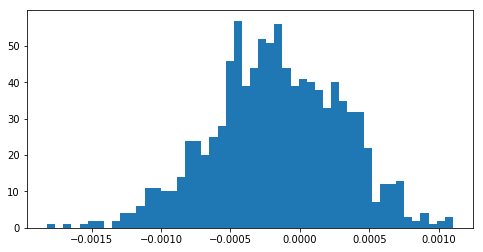

In [87]:
check_bayes(valid_pred_5, add_hacks=False)

Mean delta -0.000227
T-test: Ttest_1sampResult(statistic=-13.181063259038456, pvalue=1.0736259120384286e-36)


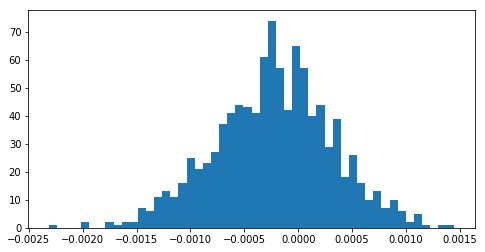

In [88]:
check_bayes(valid_pred_5, add_hacks=True)

Mean delta +0.000042
T-test: Ttest_1sampResult(statistic=5.050899427187507, pvalue=5.2256112597172847e-07)


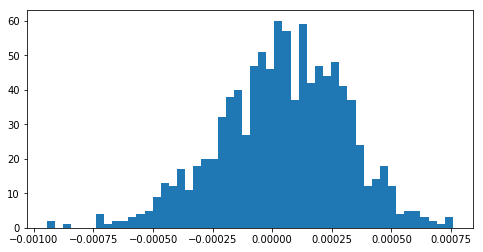

In [90]:
check_bayes(0.5 * valid_pred_4 + 0.5 * valid_pred_5, add_hacks=True)

Mean delta +0.000037
T-test: Ttest_1sampResult(statistic=5.4804007001706889, pvalue=5.372842399304969e-08)


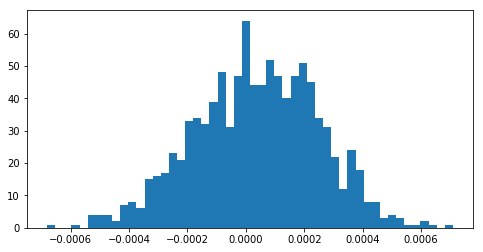

In [91]:
check_bayes(0.5 * valid_pred_4 + 0.5 * valid_pred_5, add_hacks=False)

Mean delta +0.000129, mean score 0.933865
T-test: Ttest_1sampResult(statistic=16.831938546577224, pvalue=3.6994356338562241e-56)


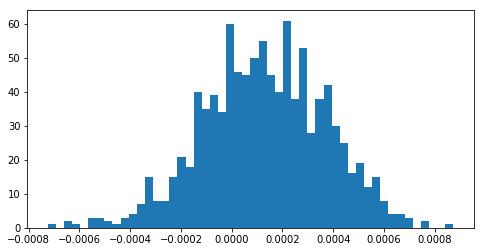

In [123]:
check_bayes(valid_pred_6, add_hacks=False)

Mean delta +0.000066, mean score 0.933802
T-test: Ttest_1sampResult(statistic=6.7212430020446732, pvalue=3.0237809957733442e-11)


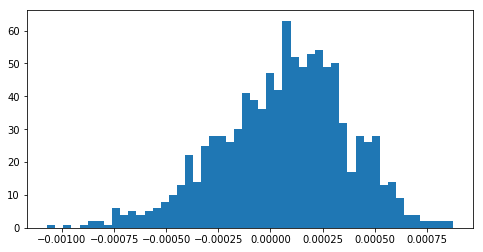

In [124]:
check_bayes(valid_pred_6, add_hacks=True)

Mean delta +0.000120, mean score 0.933917
T-test: Ttest_1sampResult(statistic=14.79447581615702, pvalue=6.265094528634159e-45)


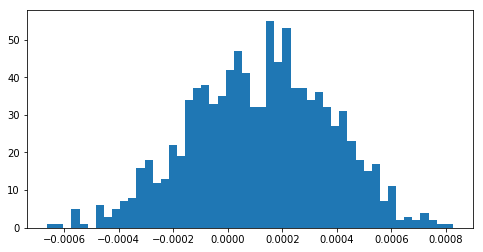

In [127]:
check_bayes(sigmoid(logit(valid_pred_6) - 0.2), add_hacks=False)

Mean delta +0.000040, mean score 0.933791
T-test: Ttest_1sampResult(statistic=4.9146973594311252, pvalue=1.0387449355800475e-06)


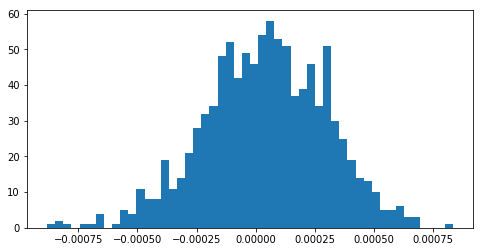

In [129]:
check_bayes(sigmoid(logit(valid_pred_6) - 0.1), add_hacks=False)

Mean delta +0.000258, mean score 0.933907
T-test: Ttest_1sampResult(statistic=30.075789389920125, pvalue=5.051045070133319e-142)


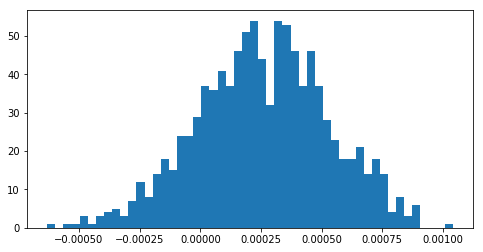

In [151]:
check_bayes((0.7 * valid_pred_6 + 0.3 * valid_pred_7), add_hacks=False)

Mean delta +0.000325, mean score 0.933887
T-test: Ttest_1sampResult(statistic=36.036042524086554, pvalue=7.1178065678254613e-183)


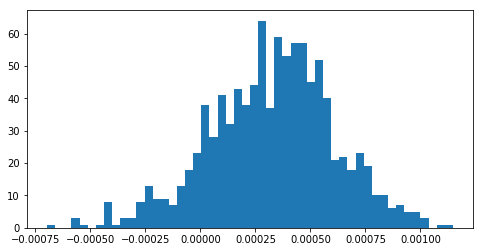

In [152]:
check_bayes((0.6 * valid_pred_6 + 0.4 * valid_pred_7), add_hacks=False)

Mean delta +0.000229, mean score 0.933863
T-test: Ttest_1sampResult(statistic=26.759100498036595, pvalue=2.2536550759139873e-119)


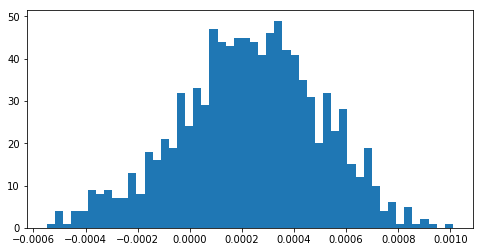

In [155]:
check_bayes(sigmoid(logit(0.7 * valid_pred_6 + 0.3 * valid_pred_7) + 0.05), add_hacks=False)

Mean delta +0.000196, mean score 0.933805
T-test: Ttest_1sampResult(statistic=16.258816989914791, pvalue=6.4882446062694241e-53)


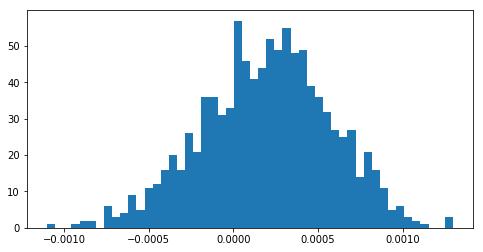

In [144]:
check_bayes(0.5 * (valid_pred_6 + valid_pred_7), add_hacks=True)

Mean delta +0.000112
T-test: Ttest_1sampResult(statistic=3.3712499186743745, pvalue=0.0010683301814363732)


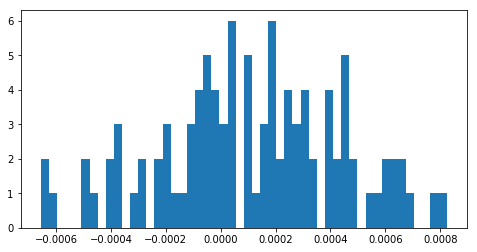

In [34]:
deltas = []
for _ in range(10):
    for train_ids, valid_ids in KFold(n_splits=10, shuffle=True).split(valid_pred.index):
        hack = valid_pred.iloc[valid_ids].copy()
        hack[hack['cloudy'] > .7] *= .7
        bayes = make_bayes_submission.get_df_prediction(hack)
        delta = (f2_score(train_flat.iloc[valid_ids], bayes) -
                 f2_score(train_flat.iloc[valid_ids], valid_pred.iloc[valid_ids] > threshold))
        deltas.append(delta)
plt.figure(figsize=(8, 4))
plt.hist(deltas, bins=50);
print('Mean delta {:+.6f}'.format(np.mean(deltas)))
print('T-test: {}'.format(ttest_1samp(deltas, 0)))

In [6]:
bayes_shifted = make_bayes_submission.get_df_prediction(sigmoid(logit(valid_pred) + 0.1))

Mean delta +0.000154
T-test: Ttest_1sampResult(statistic=28.651988829842661, pvalue=2.8791999077179275e-132)


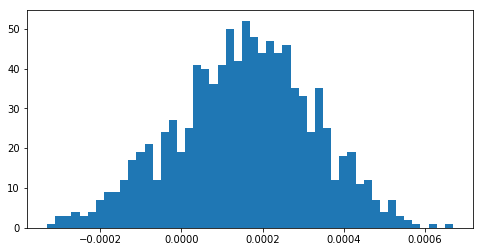

In [10]:
deltas = []
for _ in range(100):
    for train_ids, valid_ids in KFold(n_splits=10, shuffle=True).split(valid_pred.index):
        delta = (f2_score(train_flat.iloc[valid_ids], bayes_shifted.iloc[valid_ids]) -
                 f2_score(train_flat.iloc[valid_ids], valid_pred.iloc[valid_ids] > threshold))
        deltas.append(delta)
plt.figure(figsize=(8, 4))
plt.hist(deltas, bins=50);
print('Mean delta {:+.6f}'.format(np.mean(deltas)))
print('T-test: {}'.format(ttest_1samp(deltas, 0)))

In [119]:
hack = valid_pred.copy()
for cls in hack.columns:
    if cls != 'cloudy':
        hack[cls][hack['cloudy'] > .8] *= .8
bayes_shifted_hack = make_bayes_submission.get_df_prediction(hack)        

Mean delta +0.000139
T-test: Ttest_1sampResult(statistic=17.250611410018571, pvalue=1.4431135265726424e-58)


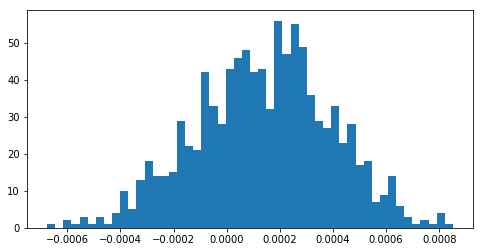

In [120]:
deltas = []
for _ in range(100):
    for train_ids, valid_ids in KFold(n_splits=10, shuffle=True).split(valid_pred.index):
        delta = (f2_score(train_flat.iloc[valid_ids], bayes_shifted_hack.iloc[valid_ids]) -
                 f2_score(train_flat.iloc[valid_ids], valid_pred.iloc[valid_ids] > threshold))
        deltas.append(delta)
plt.figure(figsize=(8, 4))
plt.hist(deltas, bins=50);
print('Mean delta {:+.6f}'.format(np.mean(deltas)))
print('T-test: {}'.format(ttest_1samp(deltas, 0)))

In [161]:
test_pred = 0.6 * test_pred_6 + 0.4 * test_pred_7
bayes_test = make_bayes_submission.get_df_prediction(test_pred)        

In [162]:
bayes_test[:3]

,agriculture,artisinal_mine,bare_ground,blooming,blow_down,clear,cloudy,conventional_mine,cultivation,habitation,haze,partly_cloudy,primary,road,selective_logging,slash_burn,water
image_name,,,,,,,,,,,,,,,,,
test_0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
test_1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
test_2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0


In [121]:
hack_test = valid_pred.copy()
for cls in hack_test.columns:
    if cls != 'cloudy':
        hack_test[cls][hack_test['cloudy'] > .8] *= .8
hack_test = make_bayes_submission.get_df_prediction(hack_test)

In [163]:
out_df = pd.DataFrame([
    {'tags': ' '.join(c for c in bayes_test.columns if row[c])
     } for image_name, row in bayes_test.iterrows()],
    index=bayes_test.index)

In [164]:
out_df[:5]

,tags
image_name,
test_0,clear primary
test_1,clear primary
test_2,partly_cloudy primary
test_3,agriculture clear cultivation primary
test_4,cloudy partly_cloudy primary


In [165]:
out_df.to_csv('../../07-20170720-232049-b7-albu-0.93374-03-albu-mean3_0.933493-bayes.csv', index_label='image_name')

In [166]:
! head ../../07-20170720-232049-b7-albu-0.93374-03-albu-mean3_0.933493-bayes.csv

image_name,tags
test_0,clear primary
test_1,clear primary
test_2,partly_cloudy primary
test_3,agriculture clear cultivation primary
test_4,cloudy partly_cloudy primary
test_5,clear primary
test_6,agriculture clear cultivation habitation partly_cloudy primary
test_7,agriculture clear habitation primary road
test_8,clear primary


In [68]:
submit = pd.read_csv('/Users/kostia/Downloads/20170720-005737-b6-albu-0.93359_weather_hack0406.csv', index_col=0)
submit[:3]

,tags
image_name,
test_0,clear primary
test_1,clear primary
test_2,partly_cloudy primary


In [99]:
out_df[(out_df != submit.loc[out_df.index])['tags']][:10]

,tags
image_name,
test_99,clear cloudy water
test_171,clear cloudy water
test_208,clear cloudy water
test_265,agriculture cloudy partly_cloudy primary
test_316,cloudy partly_cloudy primary road water
test_436,clear cloudy water
test_476,cloudy partly_cloudy primary
test_558,agriculture cloudy partly_cloudy primary water
test_604,clear cloudy water


In [100]:
submit[(out_df != submit.loc[out_df.index])['tags']][:10]

,tags
image_name,
test_99,cloudy
test_171,clear cloudy
test_208,clear water
test_265,agriculture partly_cloudy primary
test_316,cloudy partly_cloudy primary road
test_436,cloudy
test_476,cloudy
test_558,cloudy partly_cloudy primary
test_604,cloudy


In [80]:
len(out_df)

61191

In [82]:
1 - 59790 / 61191

0.022895523851546806

In [85]:
(out_df != test_pred).sum()

ValueError: Can only compare identically-labeled DataFrame objects